# Finding optimal hyper parameters for a CNN model

The point of this notebook is to obtain an optimal set of parameters for our CNN model to process time based series data. Specifically, we are processing IoT data from TON a well-kept dataset from The UNSW Group in Canberra, Australia.

The specific dataset being discussed here is the IoT Thermostat dataset.



We have pip install mealpy each time because it is not a default python package ,and every time the runtime refreshes; the package is uninstalled.

In [ ]:
%pip install mealpy==3.0.1
%pip install -U scikit-learn
%pip install imbalanced-learn
%pip install matplotlib
%pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.3/386.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 16.5 MB/s eta 0:00:00


Our main libraries used are:

*   Imblearn
*   Pandas
*   Matplot Lib
*   MealPy
*   Numpy
*   SKLearn
*   Tensorflow
*   Time



In [ ]:
import pandas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from imblearn.combine import SMOTETomek
import numpy
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
from mealpy import FloatVar, LCO
import time

# Preparing the Datasets for the CNN Model

We split off the information that indicates whether or not an attack has occured (*label*) and the types of attacks (*type*).
Now there are three dataframes:
  X - all features
  y - attack or not
  y_type - type of attack

We split again into test and train data sets and include some randomness.
**Reset_index** drops the indexes from these new dataframes.
Next, we encode the text data, add another randomness, and scale all dataframes. The X dataframe is reshaped.

In [ ]:
#Uncomment for local use
#raw_data = pandas.read_csv('../../Train_Test_IoT_dataset/Train_Test_IoT_Thermostat.csv')
#Uncomment for Google Colab
raw_data = pandas.read_csv('Train_Test_IoT_Thermostat.csv')
X = raw_data.drop(columns=['label','type'])
y = raw_data['label']
y_type = raw_data['type']

In [ ]:
# Binary
X_train, X_testsplit, y_train, y_testsplit = train_test_split(X, y, test_size=0.2, random_state=777)
# Binary validation
X_test, X_validation, y_test, y_validation = train_test_split(X_testsplit, y_testsplit, test_size=0.5, random_state=777)

#drop index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X_validation = X_validation.reset_index(drop=True)
y_validation = y_validation.reset_index(drop=True)

In [ ]:
encoder = OrdinalEncoder()
label_encoder = LabelEncoder()
X_train_encode = encoder.fit_transform(X_train)
X_test_encode = encoder.fit_transform(X_test)
y_train_encode = label_encoder.fit_transform(y_train)
y_test_encode = label_encoder.fit_transform(y_test)
X_validation_encode = encoder.fit_transform(X_validation)
y_validation_encode = label_encoder.fit_transform(y_validation)

In [ ]:
smotetomek = SMOTETomek(random_state=777)
X_rebalance, y_rebalance = smotetomek.fit_resample(X_train_encode, y_train_encode)

In [ ]:
scaler = StandardScaler()
X_rebalance = scaler.fit_transform(X_rebalance)
X_test_encode = scaler.transform(X_test_encode)

X_validation_encode = scaler.transform(X_validation_encode)

In [ ]:
X_rebalance = X_rebalance.reshape(X_rebalance.shape[0], X_rebalance.shape[1], 1)
X_test_encode = X_test_encode.reshape(X_test_encode.shape[0], X_test_encode.shape[1], 1)

X_validation_encode = X_validation_encode.reshape(X_validation_encode.shape[0], X_validation_encode.shape[1], 1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 50)             200       
                                                                 
 max_pooling1d (MaxPooling1  (None, 1, 50)             0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 1, 50)             0         
                                                                 
 batch_normalization (Batch  (None, 1, 50)             200       
 Normalization)                                                  
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 flatten (Flatten)           (None, 64)                0

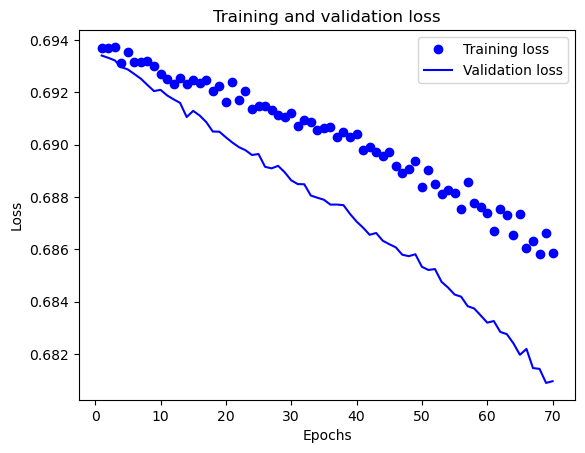

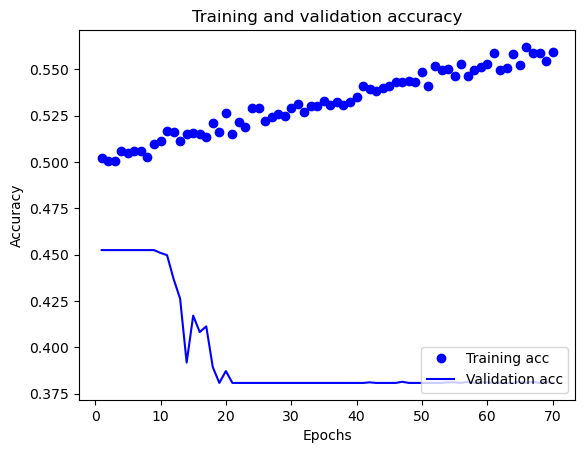


Classification Report
              precision    recall  f1-score   support

           0       0.42      0.80      0.55      1541
           1       0.00      0.00      0.00      1736

    accuracy                           0.38      3277
   macro avg       0.21      0.40      0.27      3277
weighted avg       0.20      0.38      0.26      3277


Confusion Matrix
[[1240  301]
 [1736    0]]


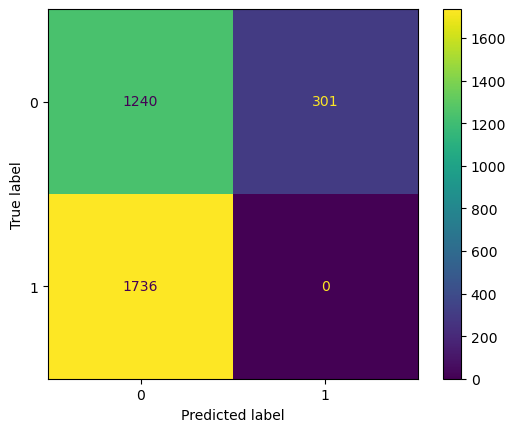

Time taken: 229.5038 seconds


In [ ]:
start_time_1 = time.perf_counter()
with tensorflow.device('/device:GPU:0'):
  # CNN model detection
  # https://keras.io/api/layers/activations/#softmax-function
  detection_model = tensorflow.keras.Sequential([
      tensorflow.keras.layers.Input(shape=(X_rebalance.shape[1],X_rebalance.shape[2])),
      tensorflow.keras.layers.Conv1D(filters=50, kernel_size=3, activation='sigmoid'),
      tensorflow.keras.layers.MaxPooling1D(pool_size=2),
      tensorflow.keras.layers.Dropout(0.3),
      tensorflow.keras.layers.BatchNormalization(),
      tensorflow.keras.layers.LSTM(64),
      tensorflow.keras.layers.Flatten(),
      # 1 layer
      tensorflow.keras.layers.Dense(512, activation='relu'),
      tensorflow.keras.layers.Dropout(0.5),
      # either attack or normal
      tensorflow.keras.layers.Dense(1, activation='sigmoid')
  ])

  detection_model.summary()
  # https://keras.io/api/losses/probabilistic_losses/#probabilistic-losses
  sgd = tensorflow.keras.optimizers.SGD(learning_rate=0.001)
  detection_model.compile(optimizer=sgd,
                loss=tensorflow.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])

  history = detection_model.fit(X_rebalance, y_rebalance, batch_size=64, epochs=70, validation_data=(X_validation_encode, y_validation_encode))
  test_loss, test_acc = detection_model.evaluate(X_test_encode, y_test_encode)

  # Make predictions
  prediction = detection_model.predict(X_test_encode)
  print(prediction)
  attack_prediction = numpy.where(prediction > 0.5, 1, 0)
  print(attack_prediction)
  print(y_test)

  # Evaluate the model
  print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}\n")
  # https://www.tensorflow.org/tutorials/keras/text_classification for training and validation loss and accuracy
  history_dict = history.history
  # print(history_dict.keys())
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  print("\n")

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()

  print("\nClassification Report")
  print(classification_report(y_test, attack_prediction))

  print("\nConfusion Matrix")
  print(confusion_matrix(y_test, attack_prediction))
  ConfusionMatrixDisplay.from_predictions(y_test, attack_prediction)
  plt.show()

end_time1 = time.perf_counter()
print(f"Time taken: {end_time1 - start_time_1:0.4f} seconds")

# Optimizing the model
Instead of looking at random number ranges for learning rates, filters, and hidden units, we have encoded specific values.

The hyper parameters we are attempting to optimize are:

*   Batch Size
*   Activation Functions
*   Learning Rates
*   Filters
*   Hidden Units


The base CNN model we made is ingested into *objective_function*.
  This is where our hyper parameters are being considered.
  It returns the Accuracy of that particular iteration.
**LB** and **UB** is set according to the list given above.



2025/04/15 01:54:55 PM, INFO, mealpy.human_based.LCO.OriginalLCO: Solving single objective optimization problem.


Accuracy 0.4524099826812744
Accuracy 0.5475899875164032
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.5475899875164032
Accuracy 0.5475899875164032
Accuracy 0.4121415615081787
Accuracy 0.5475899875164032
Accuracy 0.5475899875164032
Accuracy 0.4524099826812744
Accuracy 0.08633315563201904
Accuracy 0.4524099826812744
Accuracy 0.08633315563201904
Accuracy 0.4524099826812744
Accuracy 0.4524099826812744
Accuracy 0.08572298288345337
Accuracy 0.5475899875164032
Accuracy 0.6073825359344482
Accuracy 0.6192800402641296
Accuracy 0.5475899875164032
Accuracy 0.3923124074935913
Accuracy 0.08572298288345337
Accuracy 0.5475899875164032
Accuracy 0.4524099826812744
Accuracy 0.4524099826812744
Accuracy 0.5475899875164032
Accuracy 0.40237951278686523
Accuracy 0.4524099826812744
Accuracy 0.4524099826812744
Accuracy 0.08633315563201904
Accuracy 0.38804149627685547
Accuracy 0.08602803945541382
Accuracy 0.08572298288345337
Accuracy 0.4524099826812744
Accuracy 0.4524099826812744
Accuracy 

2025/04/15 02:34:49 PM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 1, Current best: 0.08572298288345337, Global best: 0.08572298288345337, Runtime: 1226.79016 seconds


Accuracy 0.08663821220397949
Accuracy 0.4524099826812744
Accuracy 0.5475899875164032
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.08633315563201904
Accuracy 0.25381332635879517
Accuracy 0.5475899875164032
Accuracy 0.0945698618888855
Accuracy 0.5475899875164032
Accuracy 0.5475899875164032
Accuracy 0.08572298288345337
Accuracy 0.08877366781234741
Accuracy 0.4524099826812744
Accuracy 0.08572298288345337
Accuracy 0.11470407247543335
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.08633315563201904


2025/04/15 02:49:36 PM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 2, Current best: 0.08572298288345337, Global best: 0.08572298288345337, Runtime: 887.04224 seconds


Accuracy 0.38529592752456665
Accuracy 0.08572298288345337
Accuracy 0.4524099826812744
Accuracy 0.4524099826812744
Accuracy 0.633313000202179
Accuracy 0.24984747171401978
Accuracy 0.08785843849182129
Accuracy 0.09914582967758179
Accuracy 0.08572298288345337
Accuracy 0.08633315563201904
Accuracy 0.08633315563201904
Accuracy 0.426174521446228
Accuracy 0.5475899875164032
Accuracy 0.08633315563201904
Accuracy 0.08633315563201904
Accuracy 0.3840756416320801
Accuracy 0.08633315563201904
Accuracy 0.4524099826812744
Accuracy 0.5475899875164032
Accuracy 0.08572298288345337


2025/04/15 03:04:54 PM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 3, Current best: 0.08572298288345337, Global best: 0.08572298288345337, Runtime: 917.92210 seconds


Accuracy 0.4524099826812744
Accuracy 0.10829776525497437
Accuracy 0.08572298288345337
Accuracy 0.08755338191986084
Accuracy 0.08572298288345337
Accuracy 0.08602803945541382
Accuracy 0.08633315563201904
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.08633315563201904
Accuracy 0.4524099826812744
Accuracy 0.08633315563201904
Accuracy 0.4524099826812744
Accuracy 0.4524099826812744
Accuracy 0.36607688665390015
Accuracy 0.08633315563201904
Accuracy 0.5475899875164032
Accuracy 0.09273946285247803
Accuracy 0.08633315563201904
Accuracy 0.08633315563201904


2025/04/15 03:19:59 PM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 4, Current best: 0.08572298288345337, Global best: 0.08572298288345337, Runtime: 904.68019 seconds


Accuracy 0.24984747171401978
Accuracy 0.6058572232723236
Accuracy 0.08663821220397949
Accuracy 0.4524099826812744
Accuracy 0.08572298288345337
Accuracy 0.30902987718582153
Accuracy 0.08572298288345337
Accuracy 0.08633315563201904
Accuracy 0.14399021863937378
Accuracy 0.08572298288345337
Accuracy 0.08633315563201904
Accuracy 0.4524099826812744
Accuracy 0.11653447151184082
Accuracy 0.08633315563201904
Accuracy 0.08572298288345337
Accuracy 0.08602803945541382
Accuracy 0.5475899875164032
Accuracy 0.08572298288345337
Accuracy 0.5475899875164032
Accuracy 0.08633315563201904


2025/04/15 03:35:22 PM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 5, Current best: 0.08572298288345337, Global best: 0.08572298288345337, Runtime: 922.70047 seconds


Accuracy 0.4032946825027466
Accuracy 0.5475899875164032
Accuracy 0.5475899875164032
Accuracy 0.4524099826812744
Accuracy 0.6110433042049408
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.4524099826812744
Accuracy 0.38804149627685547
Accuracy 0.08572298288345337
Accuracy 0.5475899875164032
Accuracy 0.5475899875164032
Accuracy 0.08633315563201904
Accuracy 0.08602803945541382
Accuracy 0.08633315563201904
Accuracy 0.5475899875164032
Accuracy 0.5475899875164032
Accuracy 0.08572298288345337
Accuracy 0.13087248802185059
Accuracy 0.24496644735336304


2025/04/15 03:51:25 PM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 6, Current best: 0.08572298288345337, Global best: 0.08572298288345337, Runtime: 962.82043 seconds


Accuracy 0.10280656814575195
Accuracy 0.6095179915428162
Accuracy 0.4524099826812744
Accuracy 0.5475899875164032
Accuracy 0.38133007287979126
Accuracy 0.3840756416320801
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.41244661808013916
Accuracy 0.4524099826812744
Accuracy 0.09212934970855713
Accuracy 0.4524099826812744
Accuracy 0.5475899875164032
Accuracy 0.11714458465576172
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.5475899875164032
Accuracy 0.37858450412750244
Accuracy 0.08633315563201904
Accuracy 0.08572298288345337


2025/04/15 04:07:26 PM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 7, Current best: 0.08572298288345337, Global best: 0.08572298288345337, Runtime: 961.49612 seconds


Accuracy 0.08572298288345337
Accuracy 0.3895668387413025
Accuracy 0.5475899875164032
Accuracy 0.08572298288345337
Accuracy 0.3840756416320801
Accuracy 0.08572298288345337
Accuracy 0.5475899875164032
Accuracy 0.3657718300819397
Accuracy 0.08633315563201904
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.08633315563201904
Accuracy 0.5475899875164032
Accuracy 0.6192800402641296
Accuracy 0.09029895067214966
Accuracy 0.08572298288345337
Accuracy 0.5475899875164032
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.5475899875164032


2025/04/15 04:23:19 PM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 8, Current best: 0.08572298288345337, Global best: 0.08572298288345337, Runtime: 952.69358 seconds


Accuracy 0.4524099826812744
Accuracy 0.4524099826812744
Accuracy 0.5475899875164032
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.4524099826812744
Accuracy 0.08572298288345337
Accuracy 0.08633315563201904
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.24984747171401978
Accuracy 0.5475899875164032
Accuracy 0.4524099826812744
Accuracy 0.08572298288345337
Accuracy 0.08633315563201904
Accuracy 0.08633315563201904
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.5475899875164032


2025/04/15 04:40:15 PM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 9, Current best: 0.08572298288345337, Global best: 0.08572298288345337, Runtime: 1016.48834 seconds


Accuracy 0.08572298288345337
Accuracy 0.23703479766845703
Accuracy 0.08572298288345337
Accuracy 0.5475899875164032
Accuracy 0.08572298288345337
Accuracy 0.08602803945541382
Accuracy 0.6314826011657715
Accuracy 0.08633315563201904
Accuracy 0.40054911375045776
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.5475899875164032
Accuracy 0.4524099826812744
Accuracy 0.08572298288345337
Accuracy 0.08633315563201904
Accuracy 0.5475899875164032
Accuracy 0.08602803945541382
Accuracy 0.08785843849182129
Accuracy 0.09670531749725342
Accuracy 0.2361195683479309


2025/04/15 04:54:29 PM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 10, Current best: 0.08572298288345337, Global best: 0.08572298288345337, Runtime: 853.97853 seconds


Accuracy 0.4524099826812744
Accuracy 0.5475899875164032
Accuracy 0.5475899875164032
Accuracy 0.08694326877593994
Accuracy 0.08633315563201904
Accuracy 0.08572298288345337
Accuracy 0.3895668387413025
Accuracy 0.2361195683479309
Accuracy 0.08633315563201904
Accuracy 0.08572298288345337
Accuracy 0.5475899875164032
Accuracy 0.08633315563201904
Accuracy 0.08633315563201904
Accuracy 0.5475899875164032
Accuracy 0.08633315563201904
Accuracy 0.08816349506378174
Accuracy 0.26754117012023926
Accuracy 0.08633315563201904
Accuracy 0.5475899875164032
Accuracy 0.26418548822402954


2025/04/15 05:10:36 PM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 11, Current best: 0.08572298288345337, Global best: 0.08572298288345337, Runtime: 966.96442 seconds


Accuracy 0.5475899875164032
Accuracy 0.08602803945541382
Accuracy 0.4524099826812744
Accuracy 0.08999389410018921
Accuracy 0.23062843084335327
Accuracy 0.08572298288345337
Accuracy 0.5893837809562683
Accuracy 0.426174521446228
Accuracy 0.10829776525497437
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.5475899875164032
Accuracy 0.08572298288345337
Accuracy 0.08633315563201904
Accuracy 0.10524708032608032
Accuracy 0.08633315563201904
Accuracy 0.08633315563201904
Accuracy 0.08572298288345337
Accuracy 0.5338621139526367
Accuracy 0.08572298288345337


2025/04/15 05:25:02 PM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 12, Current best: 0.08572298288345337, Global best: 0.08572298288345337, Runtime: 865.68445 seconds


Accuracy 0.08572298288345337
Accuracy 0.4524099826812744
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.0939597487449646
Accuracy 0.4524099826812744
Accuracy 0.3828554153442383
Accuracy 0.08572298288345337
Accuracy 0.08633315563201904
Accuracy 0.4524099826812744
Accuracy 0.4524099826812744
Accuracy 0.5475899875164032
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.08968883752822876
Accuracy 0.08633315563201904
Accuracy 0.24984747171401978
Accuracy 0.08572298288345337
Accuracy 0.2757779359817505
Accuracy 0.5475899875164032


2025/04/15 05:39:44 PM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 13, Current best: 0.08572298288345337, Global best: 0.08572298288345337, Runtime: 881.92034 seconds


Accuracy 0.4524099826812744
Accuracy 0.08572298288345337
Accuracy 0.4524099826812744
Accuracy 0.08877366781234741
Accuracy 0.3929225206375122
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.5475899875164032
Accuracy 0.4524099826812744
Accuracy 0.08572298288345337
Accuracy 0.0951799750328064
Accuracy 0.5475899875164032
Accuracy 0.08633315563201904
Accuracy 0.4524099826812744
Accuracy 0.08633315563201904
Accuracy 0.24618667364120483
Accuracy 0.08572298288345337
Accuracy 0.11073827743530273
Accuracy 0.4524099826812744


2025/04/15 05:55:13 PM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 14, Current best: 0.08572298288345337, Global best: 0.08572298288345337, Runtime: 929.01730 seconds


Accuracy 0.08999389410018921
Accuracy 0.08572298288345337
Accuracy 0.08633315563201904
Accuracy 0.5475899875164032
Accuracy 0.5475899875164032
Accuracy 0.08572298288345337
Accuracy 0.4688834547996521
Accuracy 0.08572298288345337
Accuracy 0.08633315563201904
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.08572298288345337
Accuracy 0.5475899875164032
Accuracy 0.08572298288345337
Accuracy 0.426174521446228
Accuracy 0.08633315563201904


2025/04/15 06:09:27 PM, INFO, mealpy.human_based.LCO.OriginalLCO: >>>Problem: P, Epoch: 15, Current best: 0.08572298288345337, Global best: 0.08572298288345337, Runtime: 854.24259 seconds


Accuracy 0.08572298288345337
Solution: [1.19442335 1.15578641 4.71080986 1.99441492 0.69592715], Fitness: 0.08572298288345337
Solution: [1.19442335 1.15578641 4.71080986 1.99441492 0.69592715], Fitness: 0.08572298288345337


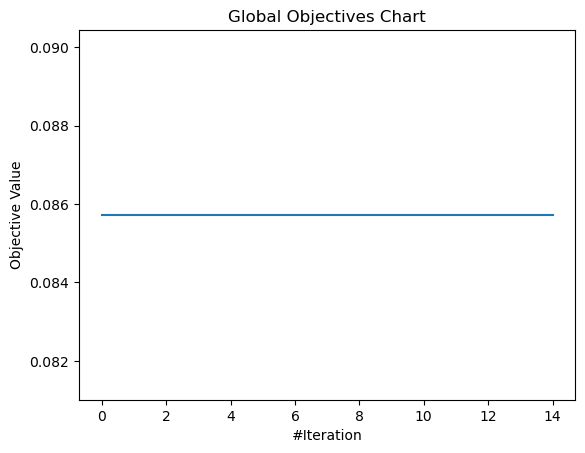

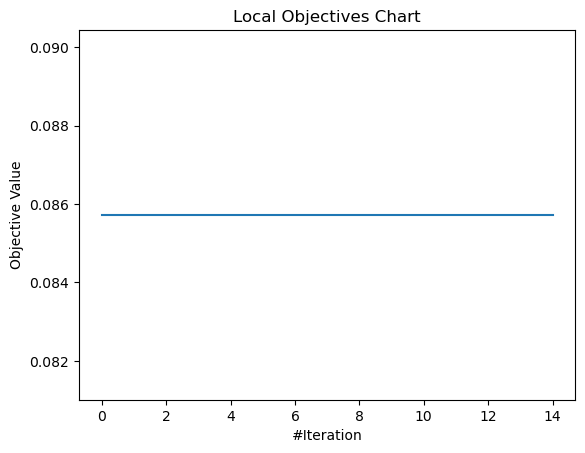

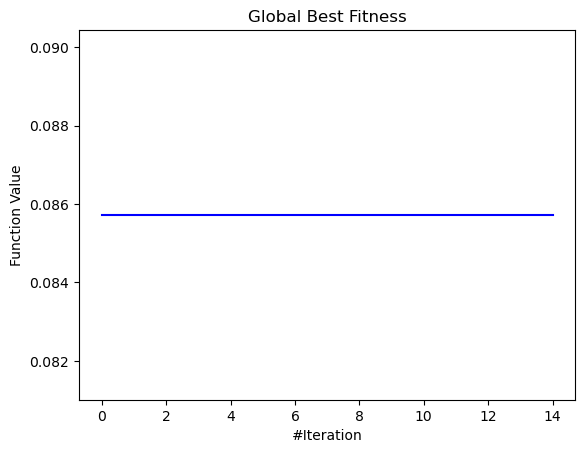

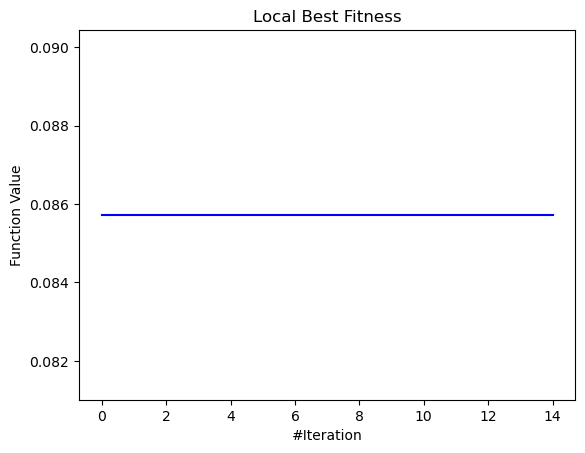

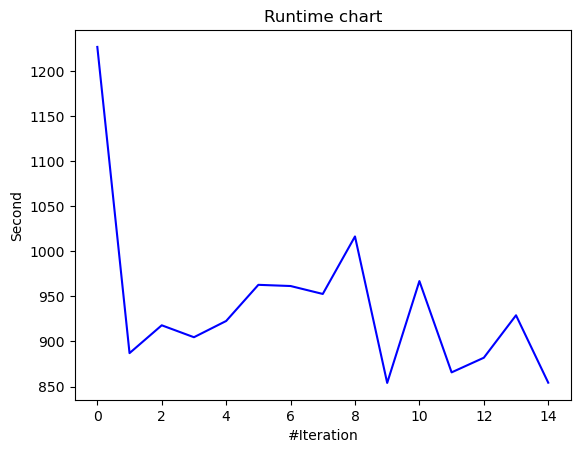

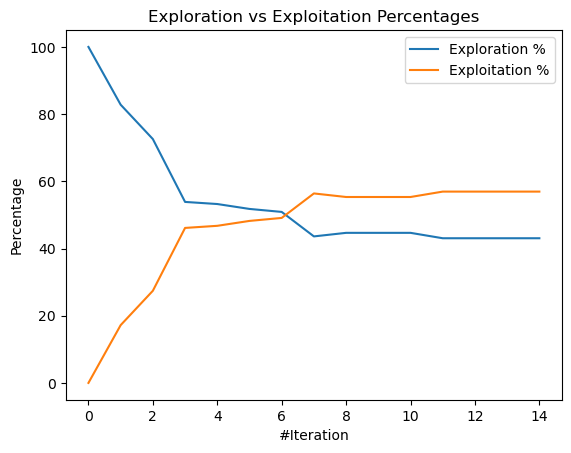

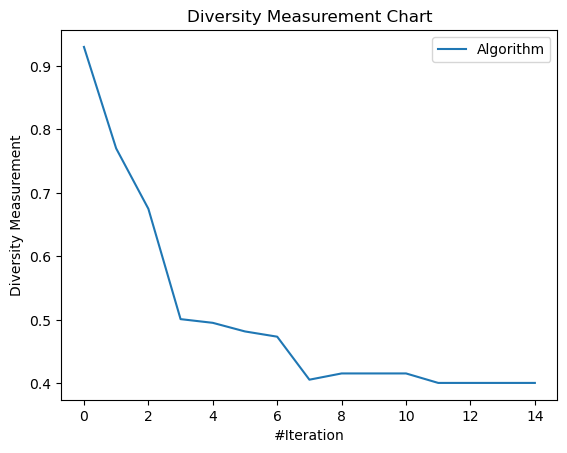

In [ ]:
BATCH_ENCODER = LabelEncoder()
BATCH_ENCODER.fit([32, 64, 128])

#act encoder --> Which activation function should be used?
ACT_ENCODER = LabelEncoder()
ACT_ENCODER.fit(['softmax', 'softplus', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'])

#Learning Rate encoder
LR_ENCODER = LabelEncoder()
LR_ENCODER.fit([0.0005, 0.001, 0.005, 0.01, 0.05, 0.1])

#Filter encoder
FILTER_ENCODER = LabelEncoder()
FILTER_ENCODER.fit([25, 50, 75])

#Hidden Units encoder
HIDDEN_ENCODER = LabelEncoder()
HIDDEN_ENCODER.fit([400, 512, 640])

def objective_function(params):
  '''RULES:
      Batch Size - 32, 64, 128
      Activation - softmax, softplus, relu, tanh, sigmoid, hard_sigmoid, linear
      Learning Rate - 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1
      Filters - 25, 50, 75
      Hidden Units - 400, 512, 640
      Dense Layers - 5, 8, 10
  '''
  batch_size = BATCH_ENCODER.inverse_transform([int(params[0])])[0]
  activation = ACT_ENCODER.inverse_transform([int(params[1])])[0]
  learning_rate = LR_ENCODER.inverse_transform([int(params[2])])[0]
  filter = FILTER_ENCODER.inverse_transform([int(params[3])])[0]
  hidden_units = HIDDEN_ENCODER.inverse_transform([int(params[4])])[0]

  model = tensorflow.keras.Sequential()
  model.add(tensorflow.keras.layers.Input(shape=(X_rebalance.shape[1], X_rebalance.shape[2]))),
  model.add(tensorflow.keras.layers.Conv1D(filters=filter, kernel_size=3, activation='sigmoid')),
  model.add(tensorflow.keras.layers.MaxPooling1D(pool_size=2)),
  model.add(tensorflow.keras.layers.Dropout(0.3)),
  model.add(tensorflow.keras.layers.BatchNormalization()),
  model.add(tensorflow.keras.layers.LSTM(64)),
  model.add(tensorflow.keras.layers.Flatten()),
  model.add(tensorflow.keras.layers.Dense(int(hidden_units), activation=activation)),
  model.add(tensorflow.keras.layers.Dropout(0.5)),
  model.add(tensorflow.keras.layers.Dense(1, activation='sigmoid'))


  optimizer = tensorflow.keras.optimizers.SGD(learning_rate=learning_rate)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

  history = model.fit(X_rebalance, y_rebalance, batch_size=batch_size, epochs=15, validation_data=(X_validation_encode, y_validation_encode), verbose=0)
  min_validation_accuracy = 1-history.history['val_accuracy'][-1]
  print(f"Accuracy {min_validation_accuracy}")
  return min_validation_accuracy

LB = [0, 0, 0, 0, 0]
UB = [2.99, 6.99, 5.99, 2.99, 2.99]

problem_dict = {
    "obj_func": objective_function,
    "bounds": FloatVar(lb=LB, ub=UB),
    "minmax": "min",
    "verbose": True
}

model = LCO.OriginalLCO(epoch=15, pop_size=20)
g_best = model.solve(problem_dict)
print(f"Solution: {g_best.solution}, Fitness: {g_best.target.fitness}")
print(f"Solution: {model.g_best.solution}, Fitness: {model.g_best.target.fitness}")
model.history.save_global_objectives_chart(filename="thermostat_lco/goc")
model.history.save_local_objectives_chart(filename="thermostat_lco/loc")

model.history.save_global_best_fitness_chart(filename="thermostat_lco/gbfc")
model.history.save_local_best_fitness_chart(filename="thermostat_lco/lbfc")

model.history.save_runtime_chart(filename="thermostat_lco/rtc")

model.history.save_exploration_exploitation_chart(filename="thermostat_lco/eec")

model.history.save_diversity_chart(filename="thermostat_lco/dc")


Solution: [1.19442335 1.15578641 4.71080986 1.99441492 0.69592715], Fitness: 0.08572298288345337

Batch Size - 32, **64**, 128

Activation - softmax, **softplus**, relu, tanh, sigmoid, hard_sigmoid, linear

Learning Rate - 0.0005, 0.001, 0.005, 0.01, **0.05**, 0.1

Filters - 25, **50**, 75

Hidden Units - **400**, 512, 640

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2, 50)          │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 50)          │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 400)            │        26,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           401 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,241 (219.69 KB)

 Trainable params: 56,141 (219.30 KB)

 Non-trainable params: 100 (400.00 B)

Epoch 1/70
442/442 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.5030 - loss: 0.9204 - val_accuracy: 0.4524 - val_loss: 0.9246
Epoch 2/70
442/442 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.5049 - loss: 0.8642 - val_accuracy: 0.4524 - val_loss: 0.6929
Epoch 3/70
442/442 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5052 - loss: 0.8262 - val_accuracy: 0.5476 - val_loss: 0.9288
Epoch 4/70
442/442 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5008 - loss: 0.8651 - val_accuracy: 0.5476 - val_loss: 0.8154
Epoch 5/70
442/442 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4950 - loss: 0.8735 - val_accuracy: 0.5476 - val_loss: 0.7894
Epoch 6/70
442/442 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5000 - loss: 0.8364 - val_accuracy: 0.5476 - val_loss: 0.7826
Epoch 7/70
442/442 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4996 - loss: 0.8288 - val_accuracy: 0.3667 - val_loss: 0.6887
Epoch 8/70
442/442 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5024 - loss: 0.8047 - val_accuracy

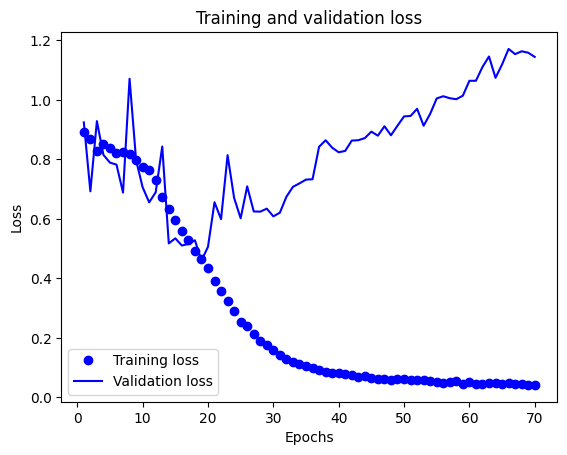

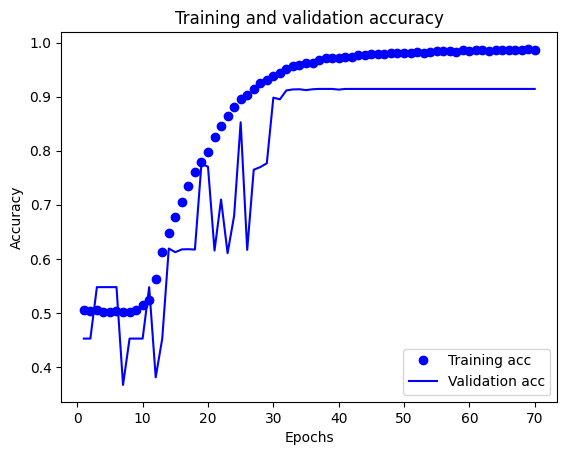


Classification Report
              precision    recall  f1-score   support

           0       1.00      0.78      0.87      1541
           1       0.84      1.00      0.91      1736

    accuracy                           0.90      3277
   macro avg       0.92      0.89      0.89      3277
weighted avg       0.91      0.90      0.89      3277


Confusion Matrix
[[1198  343]
 [   0 1736]]


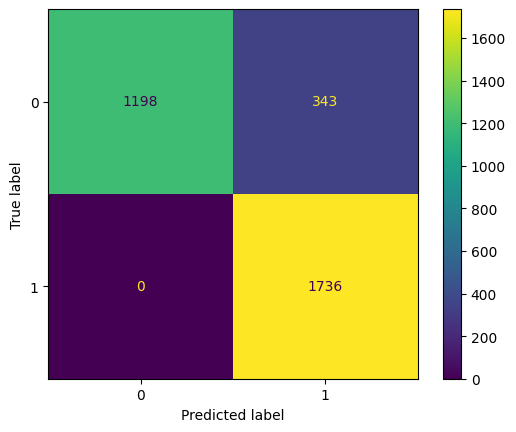

Time taken: 296.3581 seconds


In [ ]:
start_time_2 = time.perf_counter()
with tensorflow.device('/device:GPU:0'):
  # CNN model detection
  # https://keras.io/api/layers/activations/#softmax-function
  detection_model = tensorflow.keras.Sequential([
      tensorflow.keras.layers.Input(shape=(X_rebalance.shape[1],X_rebalance.shape[2])),
      tensorflow.keras.layers.Conv1D(filters=50, kernel_size=3, activation='sigmoid'),
      tensorflow.keras.layers.MaxPooling1D(pool_size=2),
      tensorflow.keras.layers.Dropout(0.3),
      tensorflow.keras.layers.BatchNormalization(),
      tensorflow.keras.layers.LSTM(64),
      tensorflow.keras.layers.Flatten(),
      # 1 layer
      tensorflow.keras.layers.Dense(400, activation='softplus'),
      tensorflow.keras.layers.Dropout(0.5),
      # either attack or normal
      tensorflow.keras.layers.Dense(1, activation='sigmoid')
  ])

  detection_model.summary()
  # https://keras.io/api/losses/probabilistic_losses/#probabilistic-losses
  sgd = tensorflow.keras.optimizers.SGD(learning_rate=0.05)
  detection_model.compile(optimizer=sgd,
                loss=tensorflow.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])

  history = detection_model.fit(X_rebalance, y_rebalance, batch_size=64, epochs=70, validation_data=(X_validation_encode, y_validation_encode))
  test_loss, test_acc = detection_model.evaluate(X_test_encode, y_test_encode)

  # Make predictions
  prediction = detection_model.predict(X_test_encode)
  print(prediction)
  attack_prediction = numpy.where(prediction > 0.5, 1, 0)
  print(attack_prediction)
  print(y_test)

  # Evaluate the model
  print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}\n")
  # https://www.tensorflow.org/tutorials/keras/text_classification for training and validation loss and accuracy
  history_dict = history.history
  # print(history_dict.keys())
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  print("\n")

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()

  print("\nClassification Report")
  print(classification_report(y_test, attack_prediction))

  print("\nConfusion Matrix")
  print(confusion_matrix(y_test, attack_prediction))
  ConfusionMatrixDisplay.from_predictions(y_test, attack_prediction)
  plt.show()

end_time2 = time.perf_counter()
print(f"Time taken: {end_time2 - start_time_2:0.4f} seconds")